# Project Machine Learning LELEC2870

## Import 


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression


In [23]:
# import data set
# X1, Y1
X_1 = pd.read_csv('X1.csv')
y_1 = pd.read_csv('Y1.csv', header=None)
y_1.columns = ["target"]

#X2, Y2
X_2 = pd.read_csv('X2.csv')



## Data Exploratory Analysis 

### valid data set check 

In [24]:
# check wether dataset contains null values
print(X_1[["Age", "Height"]].isnull().sum())

# check wether dataset contains missing values
X_1.dropna()

print(X_1.count())

Age       0
Height    0
dtype: int64
Unnamed: 0                        250
Gender                            250
Age                               250
Height                            250
family_history_with_overweight    250
FAVC                              250
FCVC                              250
NCP                               250
CAEC                              250
SMOKE                             250
CH2O                              250
SCC                               250
FAF                               250
TUE                               250
CALC                              250
MTRANS                            250
dtype: int64


-> No null or missing observations for continuous variables

### continuous variables 

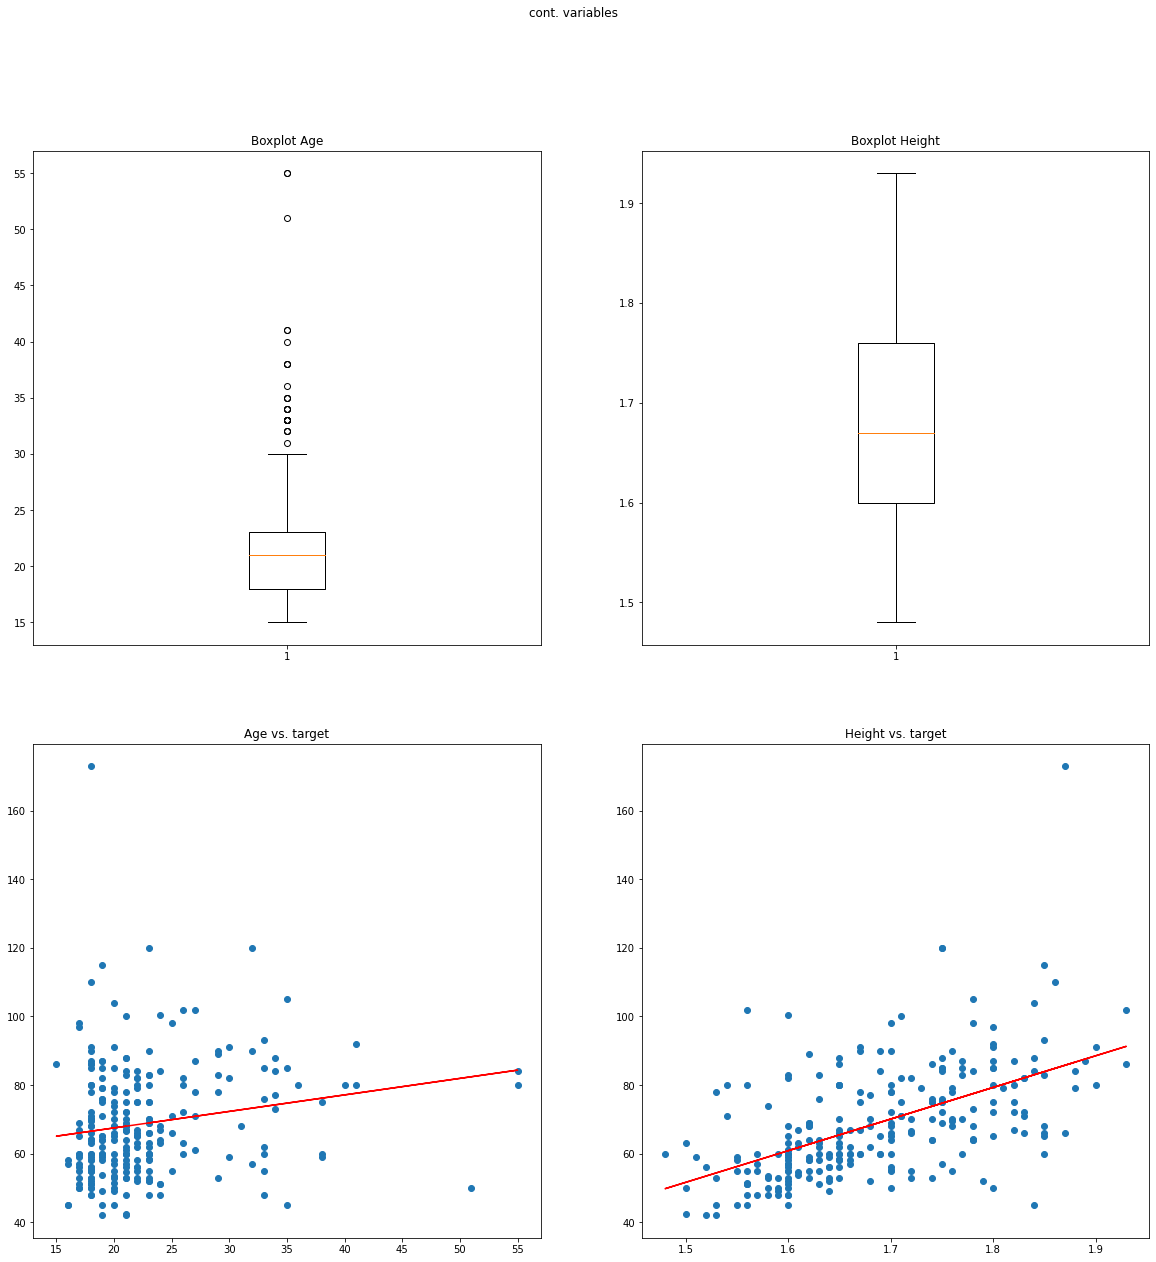

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("cont. variables")

axes[0,0].boxplot(X_1["Age"])
axes[0,0].set_title('Boxplot Age')
axes[0,1].boxplot(X_1["Height"])
axes[0,1].set_title('Boxplot Height')

""" linearity between cont. var and target var """

# scat_plot_1
x = X_1['Age']
y = y_1['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,0].scatter(x, y)
axes[1,0].plot(x, m * x + b, color='red')
axes[1,0].set_title('Age vs. target')

# scat_plot_2
x = X_1['Height']
y = y_1['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,1].scatter(x, y)
axes[1,1].plot(x, m * x + b, color='red')
axes[1,1].set_title('Height vs. target')

plt.rcParams['figure.figsize'] = (10, 10)
plt.show()





$\bold{Age}$ is highly skewed, might be a problem for linreg later on whereas, $\bold{Height}$ seems to have no outliers

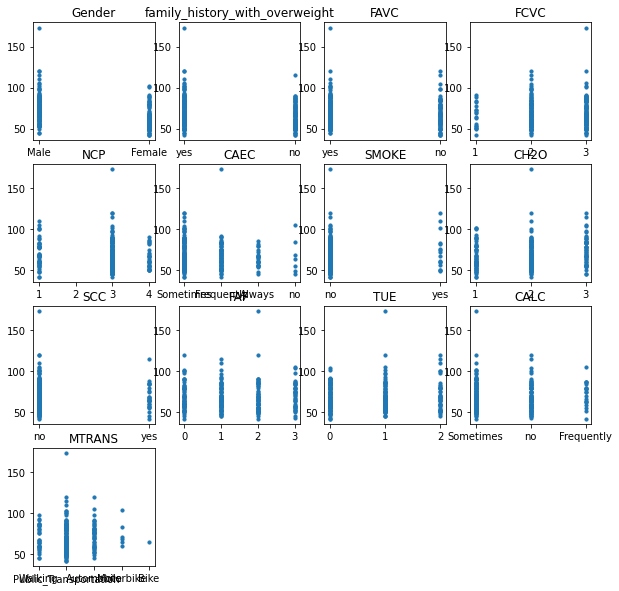

In [26]:
var_names = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
n_feats = len(var_names)
# 15 features

for i, var in enumerate(var_names):
    plt.subplot((n_feats//4+1), 4, i+1)
    plt.scatter(X_1[var], y_1, s=10)
    plt.title(var_names[i])

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout
plt.show()




E.G. MTRANS, aggréger des classes genre velo + à pied = sport/pas moteur

We need to pay attention to the fact that all the categories are not well balanced. i.e, there are way less non-smoker than smoker in the study 



In [27]:
# Data Cleaning :
# Je modifie les variable catégorielle sous forme de nombre en mots compréhensibles, c'est mieux pour la suite

# Création du dictionnaire
dummies_dict = {"FCVC": {1.0: "Never", 2.0: "Sometimes", 3.0: "Always"},
                  "NCP": {1.0: "Betw1_2", 2.0: "Three", 3.0: "Tree++"},
                  "CH2O": {1.0: "Less1L", 2.0: "Betw1_2", 3.0: "Two++"},
                  "FAF": {1.0: "no_acti", 2.0: "1_2Day", 3.0: "2_4Day", 4.0: "4_5Day"},
                  "TUE": {1.0: "0_2hour", 2.0: "3_5hour", 3.0: "Five++"}}

# Remplacement dans le dataframe
X_1 = X_1.replace(dummies_dict)
X_2 = X_2.replace(dummies_dict)

print(X_1.shape)
print(X_2.shape)

# Binarized categorical variables
X_1_cleaned = pd.get_dummies(X_1,
                                   columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                            "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                   prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                           "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"], )#drop_first=True)

X_2_cleaned = pd.get_dummies(X_2,
                                   columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                            "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                   prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                           "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"], )#drop_first=True )

X_2_cleaned = X_2_cleaned.drop(columns=['CALC_Always', 'Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])
X_1_cleaned = X_1_cleaned.drop(columns=['Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])

# explanatory with age and height scaled in order to give much more importance to dummies variables 
from sklearn.preprocessing import StandardScaler
min_max_scaler = StandardScaler()

X_1_cleaned[['Age', 'Height']] = min_max_scaler.fit_transform(X_1_cleaned[['Age', 'Height']])
X_2_cleaned[['Age', 'Height']] = min_max_scaler.fit_transform(X_2_cleaned[['Age', 'Height']])


X_1_cleaned = X_1_cleaned.iloc[: , 1:]
X_2_cleaned = X_2_cleaned.iloc[: , 1:]



(250, 16)
(248, 16)


In [28]:
print(X_1_cleaned.shape)
print(X_2_cleaned.shape)

(250, 35)
(248, 35)


## Scoring


In [29]:
# bmi calculator 
def get_bmi(w, h):
    return w/h**2


# RMSE calculator  
def compute_rmse(predict, target):
        # SOLUTION
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

def score_weight_class(bmi_pred, bmi_true, low, high):
    tol = 1
    vpred = (bmi_pred>=low-tol) & (bmi_pred<high+tol)
    vtrue = (bmi_true>=low) & (bmi_true<high)
    if vtrue.sum()==0:
        print("no true sample here")
        return 0
    
    rmse = np.sqrt(((bmi_true[vtrue]-bmi_pred[vtrue])**2).mean())
    rmse = rmse/(high-low+tol)
    acc = (vpred&vtrue).sum()/vtrue.sum()
    return rmse*(1-acc)


def score_regression(ytrue, ypred, height):
    bmi_pred = ypred/(height*height)
    bmi_true = ytrue/(height*height)

    score = []
    for bmi_low, bmi_high in zip([0,18.5,25,30],[18.5, 25, 30, 100]):
        score.append(score_weight_class(bmi_pred, bmi_true, low = bmi_low, high = bmi_high))
        return np.mean(score)


def mybmi(X,y) :
    return pd.DataFrame(y/(X**2), columns =["bmi"])
     


In [30]:
bmi = mybmi(X_1["Height"],y_1["target"])
bmi["bmi"] = pd.cut(bmi["bmi"], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3])

bmi = bmi.values.ravel()
#print(bmi)
print(bmi.shape)

(250,)


## model : linear regression 

In [31]:
model = LinearRegression().fit(X_1_cleaned,y_1)

print(X_1_cleaned.shape, "X1")
print(X_2_cleaned.shape, "X2")


y_pred = model.predict(X_2_cleaned)
"""
# R^2
r_sq = model.score(X_1_cleaned, y_1)
print('coefficient of determination:', round(r_sq, 4))

# RMSE 
print(round(compute_rmse(y_pred, y_1),4))"""



(250, 35) X1
(248, 35) X2


"\n# R^2\nr_sq = model.score(X_1_cleaned, y_1)\nprint('coefficient of determination:', round(r_sq, 4))\n\n# RMSE \nprint(round(compute_rmse(y_pred, y_1),4))"

# Multilayer perceptron

## division en train et test set

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [33]:
X_train, X_test, bmi_train, bmi_test = train_test_split(X_1_cleaned, bmi, test_size=0.3, shuffle=True)


Le score est dégueulasse, on va faire explorer les différents paramètres du NN pour optimiser

In [34]:
# Choice of the classifier

mlp = MLPClassifier(max_iter=5000)

# Define a hyper-parameter space to search
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}



clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, bmi_train)


# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}

"""
# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""


"""
# Prediction
y_true, y_pred = DEAP_y_test , clf.predict(DEAP_x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))"""



Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


"\n# Prediction\ny_true, y_pred = DEAP_y_test , clf.predict(DEAP_x_test)\n\nfrom sklearn.metrics import classification_report\nprint('Results on the test set:')\nprint(classification_report(y_true, y_pred))"

In [35]:
# On teste les paramètres {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}

X_train, X_test, bmi_train, bmi_test = train_test_split(X_1_cleaned, bmi, test_size=0.3)
clf = MLPClassifier(random_state=1, max_iter=10000, activation ="tanh", alpha=0.05, hidden_layer_sizes=(100,),
            learning_rate="constant", solver="sgd").fit(X_train, bmi_train)

#print(clf.score(X_test, bmi_test))

#print(clf.predict_proba(X_2_cleaned[:1]))
#print(clf.predict(X_2_cleaned[:20]))


M = 100
scorer = [0]*M

for i in range(M) :
    X_train, X_test, bmi_train, bmi_test = train_test_split(X_1_cleaned, bmi, test_size=0.3)
    clf = MLPClassifier(random_state=1, max_iter=10000, activation ="tanh", alpha=0.05, hidden_layer_sizes=(100,),
            learning_rate="constant", solver="sgd").fit(X_train, bmi_train)

    scorer[i] = clf.score(X_test, bmi_test)


print(np.mean(scorer))






0.6308


# Exemple 